In [133]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
import glob
import scipy

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from sklearn.metrics import recall_score, precision_score
from models import save_model, generate_model_CNN, plot_performance
from generators import generator, decode

from ripple_detection import Karlsson_ripple_detector, Kay_ripple_detector
from ripple_detection.simulate import simulate_time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
file_list = glob.glob('../data/processed_data/*')

data = dict()

for f in file_list:
    name = f.split('/')[-1]
    print(name)
    file = np.load(os.path.join(f, 'all.npy')).item()
    data[name] = file
    

m4020_session2
m4015_session2
m4021_session1
m4017_session3
m4019_session1


In [135]:
path = os.path.join(file_list[0], 'all.npy')
d = np.load(path).item()
periods = d['ripple_periods']
times = d['time']
ripple_times = d['ripple_times']
ripple_index = d['ripple_index']
X = d['X']
ripple_time_index = d['ripple_time_index']

In [136]:
ripple_time_index.shape, periods.shape

((78,), (225, 2))

In [140]:
batch = list()
label = list()
window_size = 0.200 * d['sf']
print(window_size, window_size/d['sf'])
half_wdith = int(window_size/2)

for i in range(ripple_index.shape[0]):
    mask = np.zeros_like(times)
    full_ripple_times = np.zeros_like(times)
    full_ripple_times[ripple_time_index] = 1
    ripple_center = int(np.round((ripple_index[i,1]+ripple_index[i,0])/2))
    mask[ripple_center-half_wdith:ripple_center+half_wdith] = 1
    mask = np.array(mask, dtype=bool)
    batch.append(X[mask])
    overlap = np.sum(full_ripple_times * mask), np.sum(mask)
    if overlap[0]>0:
        label.append(1)
    else:
        label.append(0)
    print(np.sum(full_ripple_times * mask), np.sum(mask))
    

125.0 0.2
1.0 124
0.0 124
1.0 124
1.0 124
1.0 124
0.0 124
1.0 124
1.0 124
0.0 124
0.0 124
0.0 124
1.0 124
0.0 124
0.0 124
0.0 124
1.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
1.0 124
1.0 124
0.0 124
1.0 124
0.0 124
1.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
1.0 124
1.0 124
1.0 124
0.0 124
0.0 124
1.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
1.0 124
1.0 124
1.0 124
0.0 124
0.0 124
0.0 124
0.0 124
1.0 124
1.0 124
1.0 124
1.0 124
1.0 124
1.0 124
0.0 124
0.0 124
0.0 124
0.0 124
1.0 124
1.0 124
0.0 124
0.0 124
1.0 124
0.0 124
0.0 124
1.0 124
1.0 124
0.0 124
0.0 124
0.0 124
1.0 124
1.0 124
0.0 124
0.0 124
0.0 124
1.0 124
0.0 124
0.0 124
0.0 124
0.0 124
0.0 124
1.0 124
1.0 124
0.0 124
0.0 124
1.0 124
0.0 12

In [142]:
np.sum(label)/len(label)

0.3111111111111111

<IPython.core.display.Javascript object>


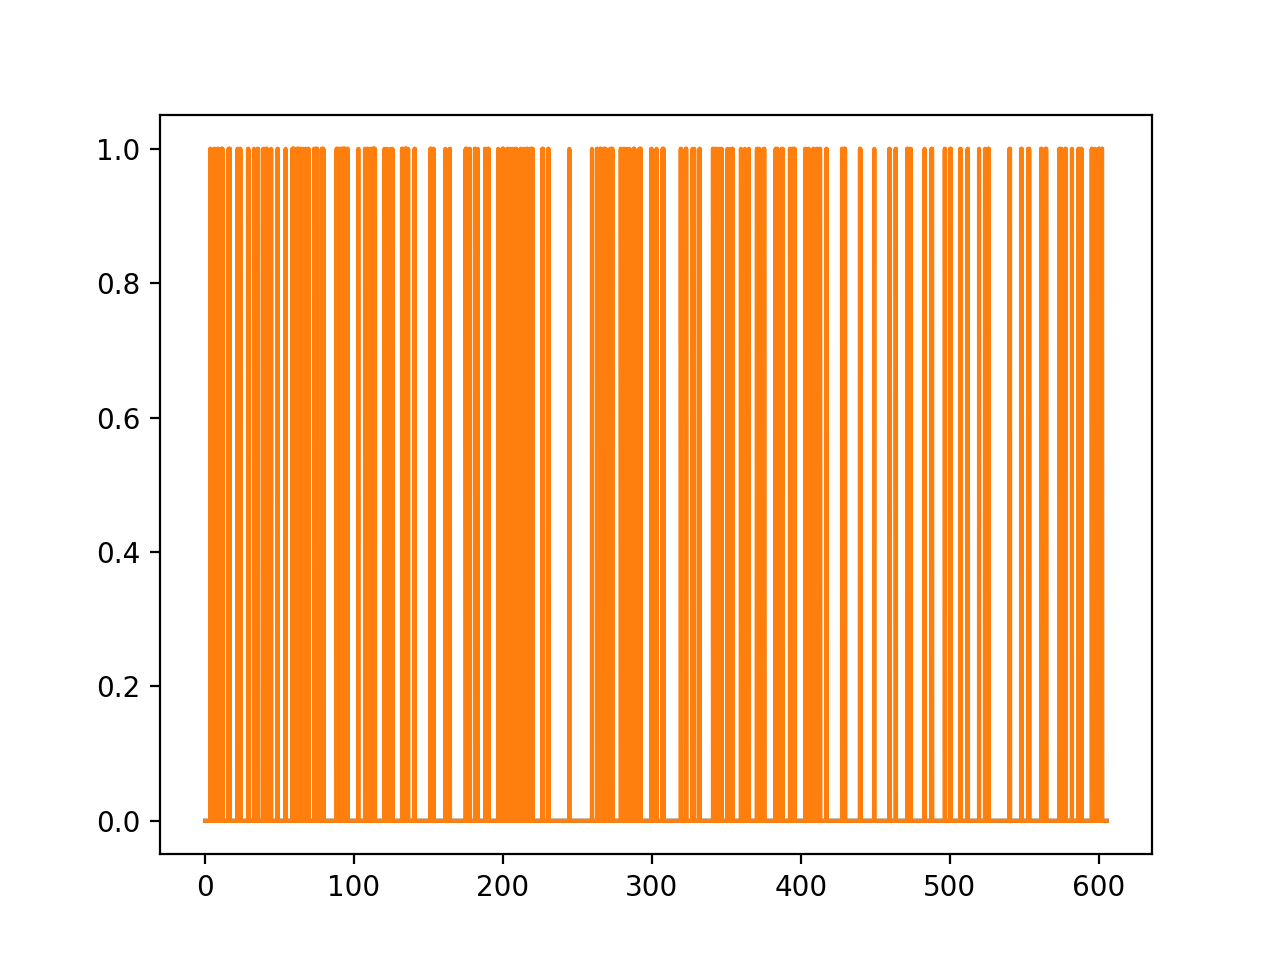

In [129]:
plt.figure()
plt.plot(times, mask)
plt.plot(times, full_ripple_times)
plt.show()

376360

(605.5488, 2408.7024)

<IPython.core.display.Javascript object>


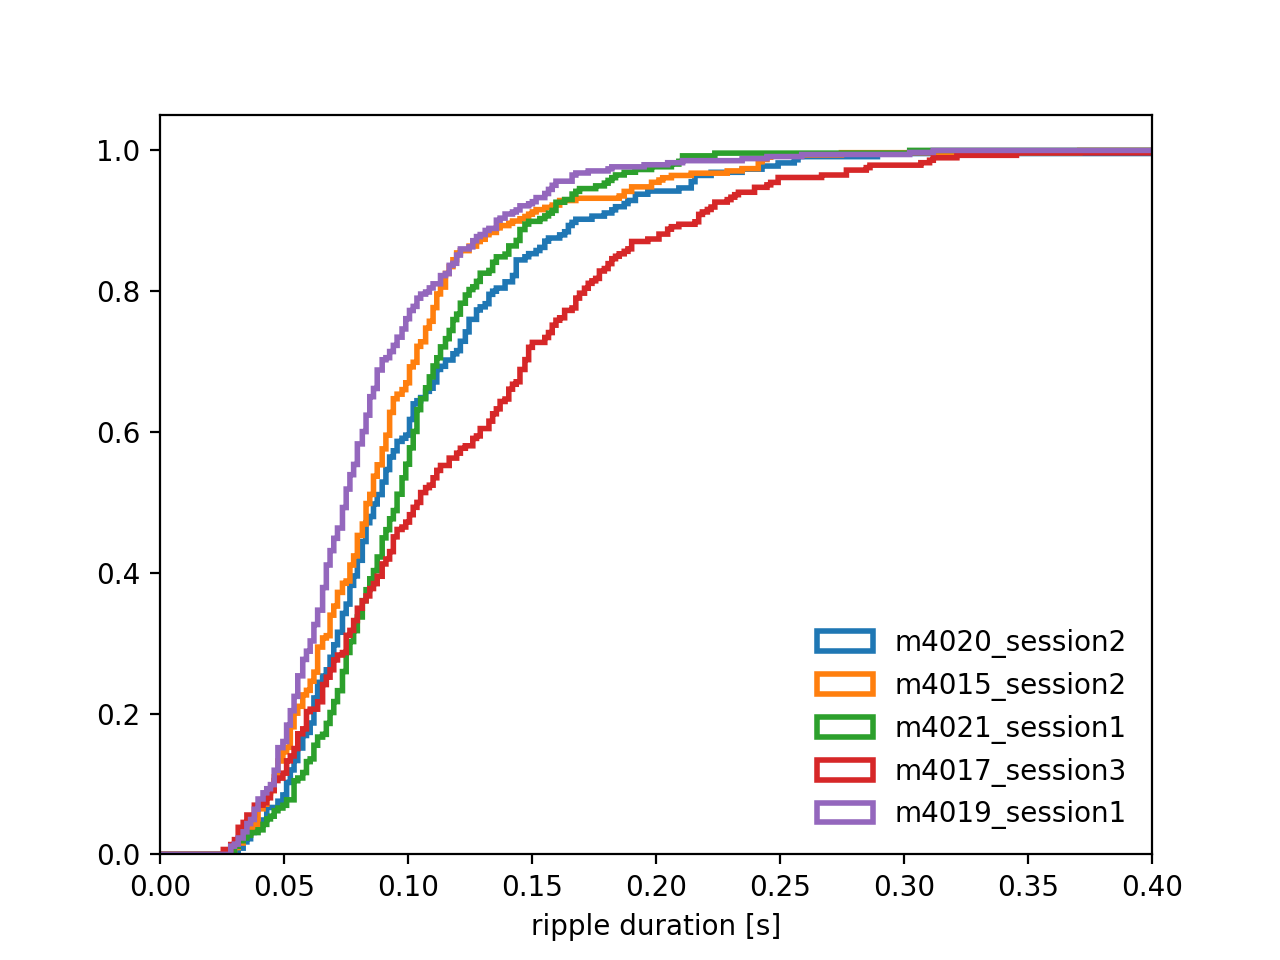

In [43]:
bins = np.linspace(0, 0.5, 1000)
plt.figure()
for k in data.keys():
    deltas = np.diff(data[k]['ripple_periods'], axis=1)
    plt.hist(deltas, bins=bins, cumulative=True, histtype='step', density=1, lw=2, label=k)
plt.xlabel(r'ripple duration [s]')
plt.xlim(0, 0.4)
plt.legend(framealpha=0, loc='lower right')
plt.show()

In [44]:
for k in data.keys():
    fraction = np.sum(data[k]['y']) / data[k]['y'].shape
    print('Session %s has a ripple fraction of %.2f%%' %(k, 100*float(fraction)))

Session m4020_session2 has a ripple fraction of 3.80%
Session m4015_session2 has a ripple fraction of 4.73%
Session m4021_session1 has a ripple fraction of 4.28%
Session m4017_session3 has a ripple fraction of 5.70%
Session m4019_session1 has a ripple fraction of 4.78%


In [7]:
X = data[list(data.keys())[0]]['X'].flatten()
t = data[list(data.keys())[0]]['time'].flatten()
y = data[list(data.keys())[0]]['y'].flatten()
boundaries = data[list(data.keys())[0]]['ripple_periods']


t_true = data[list(data.keys())[0]]['ripple_times'].flatten()

<IPython.core.display.Javascript object>


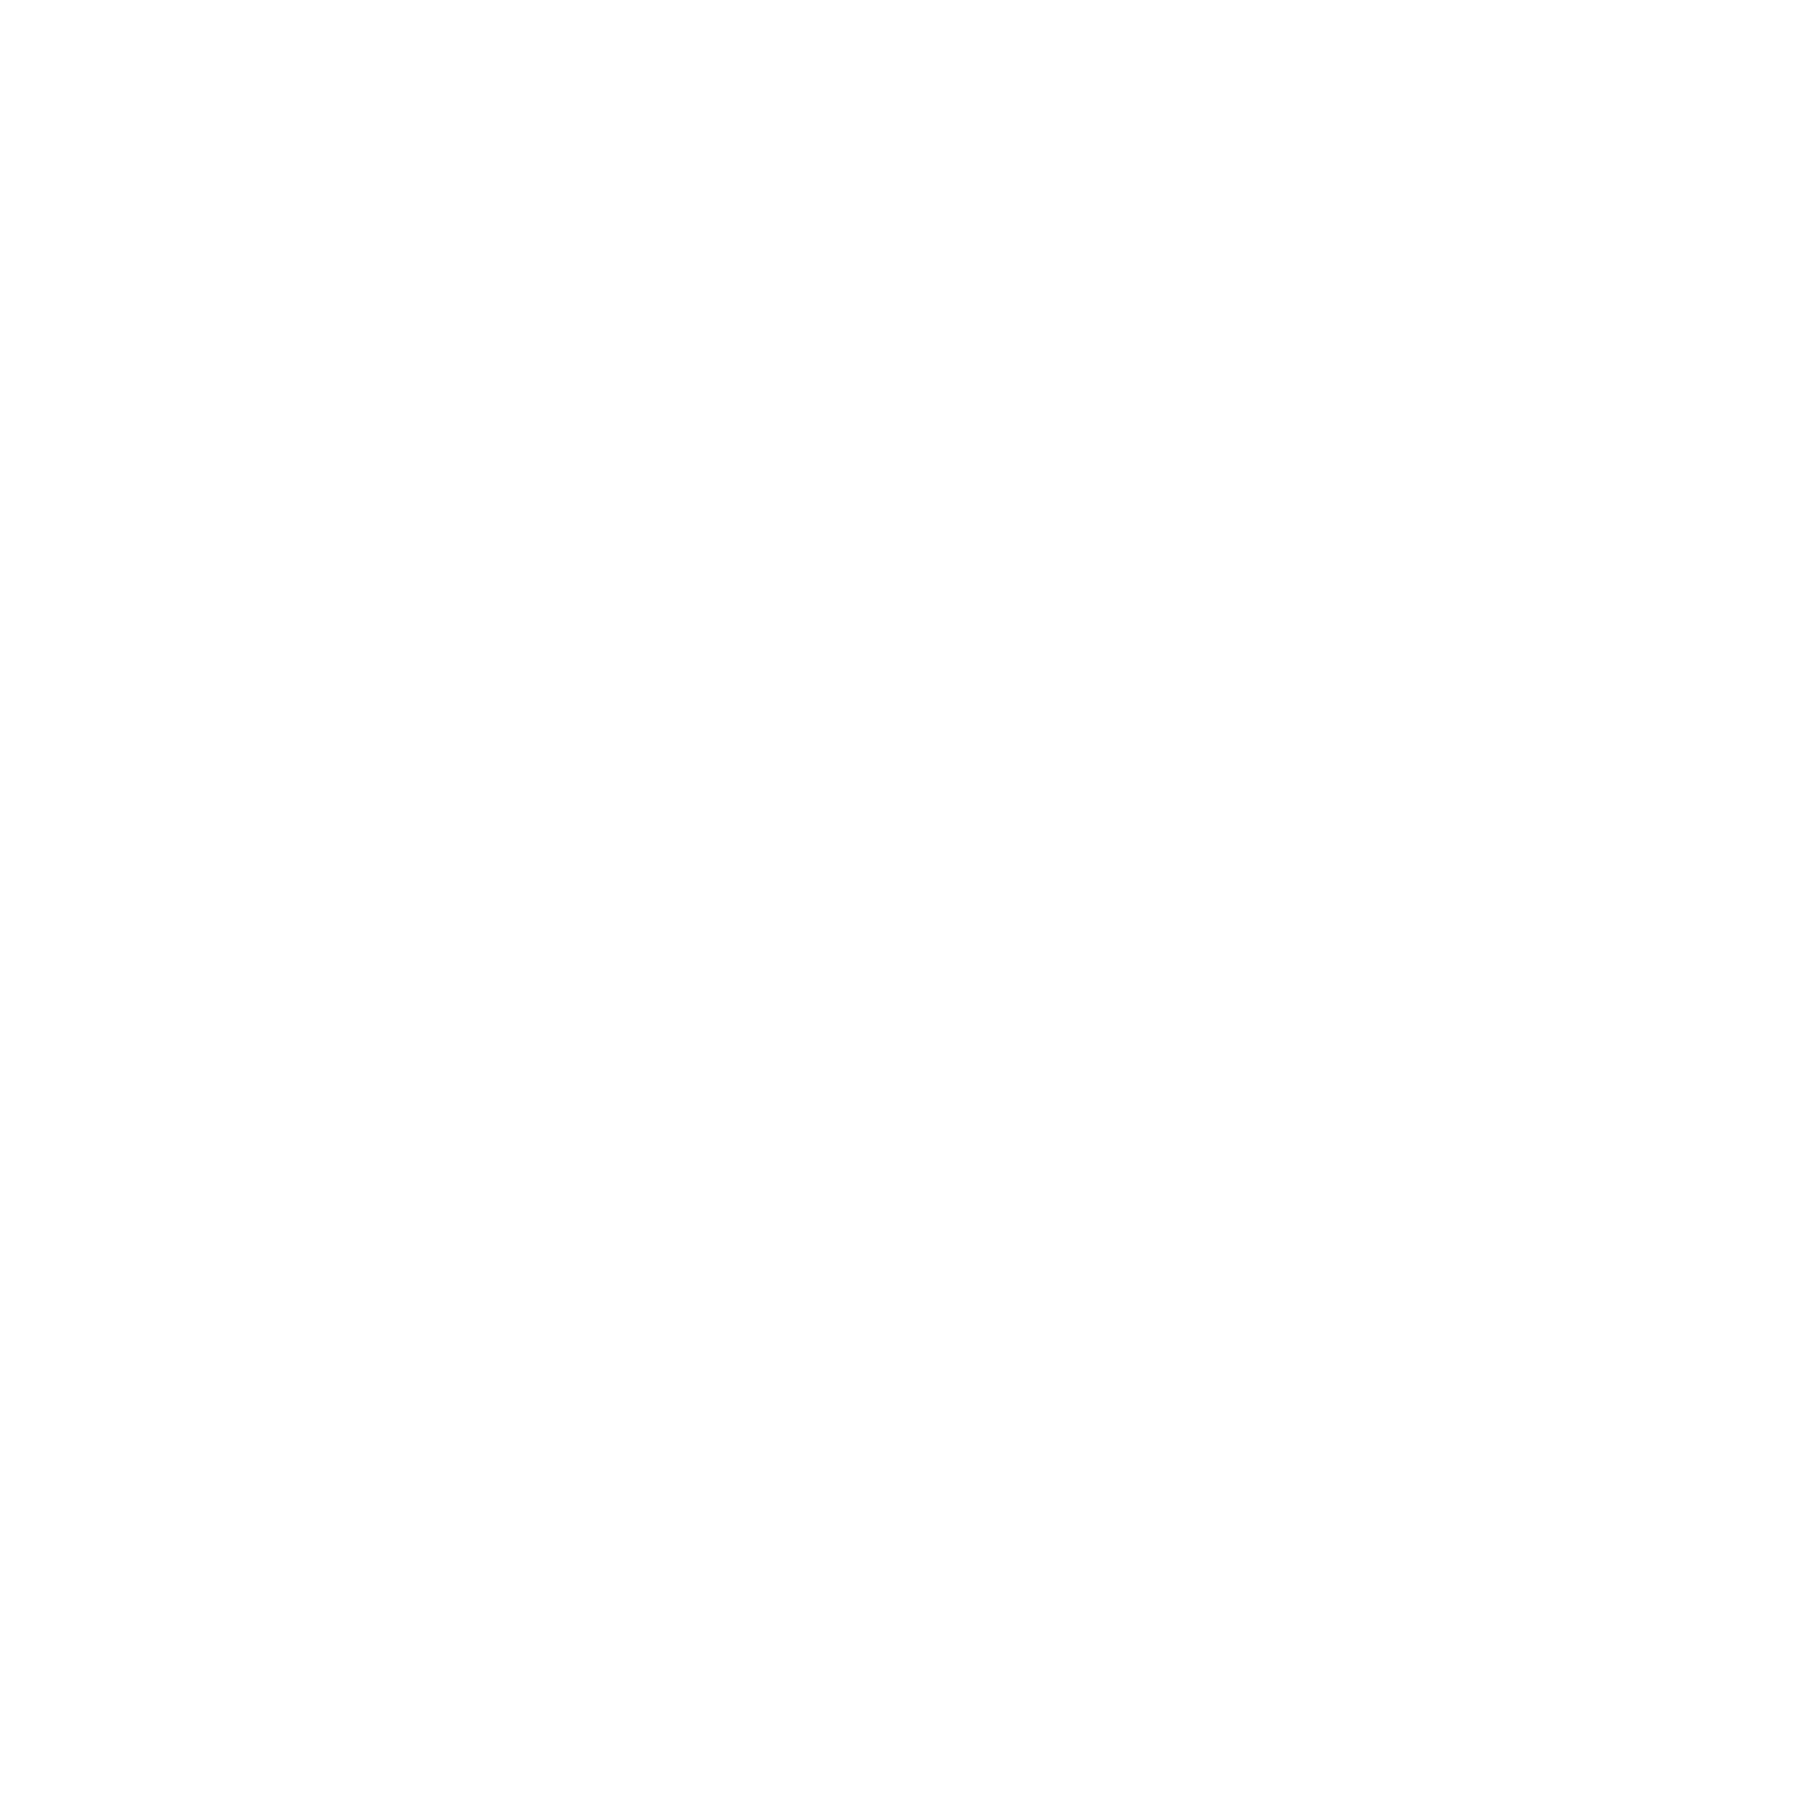

ValueError: x and y must have same first dimension, but have shapes (378469,) and (1509321, 1)

In [45]:
plt.figure(figsize=(9,9))
plt.plot(t, X)


for b in boundaries:
    plt.axvspan(b[0], b[1], alpha=0.2, color='blue', lw=0)
    
# for b in boundaries2:
#     plt.axvspan(b[0], b[1], alpha=0.2, color='yellow', lw=0)
    
# for b in t2[t_true]:
#     plt.axvline(x=b, color='black', alpha=0.5)

plt.show()

In [ ]:
data.keys()

In [10]:
# Create an array to return to
X = 'empty'
y = 'empty'

for k in list(data.keys())[:-1]:
    if X=='empty':
        X = data[k]['X']
        y = data[k]['y']
    else:
        X = np.concatenate([X, data[k]['X']])
        y = np.concatenate([y, data[k]['y']])
    print(k)
    
np.save('../data/merged_data/X_train.npy', X)
np.save('../data/merged_data/y_train.npy', y)


np.save('../data/merged_data/X_test.npy', data[list(data.keys())[-1]]['X'])
np.save('../data/merged_data/y_test.npy', data[list(data.keys())[-1]]['y'])

m4020_session2
m4015_session2
m4021_session1
m4017_session3


/Users/astasik/anaconda3/envs/machine/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [46]:
pwd

'/Users/astasik/Desktop/ANN_Ripple_Detection/ANNs'